In [1]:
%matplotlib inline
from matplotlib import gridspec, cm
from plot import bootstrap_samples_mean, StyleCycler
from typing import List, Union
import matplotlib.pyplot as plt
from matplotlib import ticker
import pandas
import numpy as np
import functools

plt.style.use('seaborn')
plt.style.use('seaborn-paper')
plt.style.use('tableau-colorblind10')
plt.rcParams.update({
    'figure.figsize': (3.6, 2.23),
    'text.usetex': True,
    'legend.borderpad': 0,
    'xtick.bottom': True,
    'xtick.major.size': 2,
    'xtick.minor.size': 1,
    'lines.markersize': 3,
    'lines.linewidth': 0.5,
    'errorbar.capsize': 4,
    'lines.markeredgewidth': 0.8
})

## Notes

1. Chose a set of clique size (i.e. 10 / 15 / 20 / 30 or something like that)
2. Aggregate by added (for a missing added) or by added (by a fixed missing)
3. Plot ratio and time, which are the metrics

In [2]:
raw2_results = pandas.read_csv('../results/quasi2.csv', index_col=0)
raw3_results = pandas.read_csv('../results/quasi3.csv', index_col=0)
raw4_results = pandas.read_csv('../results/quasi4.csv', index_col=0)

In [3]:
default_algo = dict(
    find2 = 'Find2',
    findq = 'PresQ',
    findqg = 'PresQ (grow)'
)

In [4]:
def plot_results(raw: pandas.DataFrame, fix:dict, groupby: str, algorithms: dict=default_algo, xlabel: str=None, fig=None, gs=None, title:str=None,
                 ylabel:bool=False, legend: bool=False, sharey: List = []):
    nsamples = 500
    
    cycler = StyleCycler(['o', 's', 'D'], ['--', '-.', ':'], plt.rcParams['axes.prop_cycle'])
    
    if fig is None:
        fig = plt.figure()
    
    mask = functools.reduce(lambda a, b: a & b, [raw[k] == v for k, v in fix.items()])
    masked = raw[mask]

    agg_mean = dict()
    agg_std = dict()
    for name, grp in masked.groupby(groupby):
        sample_means = pandas.DataFrame([grp.sample(frac=1, replace=True).mean() for _ in range(nsamples)])
        agg_mean[name] = sample_means.mean()
        agg_std[name] = sample_means.std()
    agg_mean = pandas.DataFrame(agg_mean).T
    agg_std = pandas.DataFrame(agg_std).T
    
    agg_timeout = masked.groupby([groupby]).agg({f'{algo}_time': lambda x: x.isnull().sum() for algo in algorithms})
    agg_timeout /= masked.groupby([groupby]).agg({f'{algo}_time': lambda x: len(x) for algo in algorithms})
    agg_timeout *= 100
    
    if gs is None:
        grid = gridspec.GridSpec(ncols=1, nrows=3, hspace=0, figure=fig)
    else:
        grid = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=3, hspace=0.15, subplot_spec=gs)
       
    # Ratio
    ax_ratio = fig.add_subplot(grid[0, 0], sharey=sharey[0] if sharey else None)
    for (algo, label), (marker, line, color) in zip(algorithms.items(), cycler):
        ax_ratio.errorbar(agg_mean.index, agg_mean[f'{algo}_jaccard'], yerr=agg_std[f'{algo}_jaccard'],
                          marker=marker, linestyle=line,
                          label=label, c=color)        
    if title:
        ax_ratio.set_title(title)
    ax_ratio.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax_ratio.yaxis.grid(True, which='minor', linewidth=0.1)
    
    # Time
    ax_time = fig.add_subplot(grid[1, 0], sharex=ax_ratio, sharey=sharey[1] if sharey else None)
    for (algo, label), (marker, line, color) in zip(algorithms.items(), cycler):
        ax_time.errorbar(agg_mean.index, agg_mean[f'{algo}_time'], yerr=agg_std[f'{algo}_time'],
                         marker=marker, linestyle=line,
                         label=label, c=color)
        
    ax_time.set_yscale('log')
    #ax_time.yaxis.grid(True, which='minor', linewidth=1)
               
    # Timeouts
    if len(agg_mean.index) > 2:
        bar_width = (agg_mean.index[-1] - agg_mean.index[-2])/4.5
    else:
        bar_width = 0.01
    
    ax_timeout = fig.add_subplot(grid[2, 0], sharex=ax_ratio, sharey=sharey[2] if sharey else None)
    for i, ((algo, label), (marker, line, color)) in enumerate(zip(algorithms.items(), cycler), -1):
        ax_timeout.bar(agg_timeout.index + i * bar_width, agg_timeout[f'{algo}_time'], width=bar_width, label=label, color=color)
    ax_timeout.yaxis.set_major_formatter(ticker.StrMethodFormatter("${x:.0f}\%$"))
    ax_timeout.set_yticks([0, 50, 100])
        
    if ylabel:
        ax_ratio.set_ylabel('Jaccard idx.')
        ax_time.set_ylabel('Time (s)')
        ax_timeout.set_ylabel('Timeouts')
        fig.align_ylabels([ax_ratio, ax_time, ax_timeout])
    
    ax_timeout.set_xlabel(xlabel)
    ax_timeout.set_xticks(agg_mean.index[1::2])
    ax_timeout.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax_timeout.xaxis.grid(False)
    ax_timeout.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax_timeout.yaxis.grid(True, which='minor', linewidth=0.1)
    
    plt.setp(ax_ratio.get_xaxis(), visible=False)
    plt.setp(ax_time.get_xaxis(), visible=False)
    
    if sharey:
        plt.setp(ax_ratio.get_yticklabels(), visible=False)
        plt.setp(ax_time.get_yticklabels(), visible=False)
        plt.setp(ax_timeout.get_yticklabels(), visible=False)
    
    if legend:
        ax_timeout.legend(loc='upper center', bbox_to_anchor=(0.5, -0.7), ncol=len(algorithms))
    
    return fig, ax_ratio, ax_time, ax_timeout

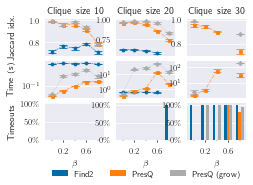

In [5]:
fig = plt.figure()
gs0 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig, wspace=0.2)

plot_results(raw2_results, dict(missing=0.1, clique=10), groupby='added', xlabel='$\\beta$', fig=fig, gs=gs0[0], title='Clique size 10', ylabel=True)
plot_results(raw2_results, dict(missing=0.1, clique=20), groupby='added', xlabel='$\\beta$', fig=fig, gs=gs0[1], title='Clique size 20', legend=True)
plot_results(raw2_results, dict(missing=0.1, clique=30), groupby='added', xlabel='$\\beta$', fig=fig, gs=gs0[2], title='Clique size 30')

fig.savefig('/home/aalvarez/Downloads/2hyper_beta.eps', bbox_inches='tight', pad_inches=0.05)

plt.show()

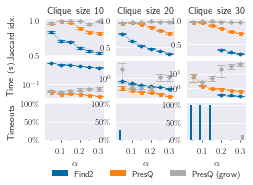

In [6]:
fig = plt.figure()
gs0 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig, wspace=0.2)

plot_results(raw2_results, dict(added=0.0, clique=10), groupby='missing', xlabel='$\\alpha$', fig=fig, gs=gs0[0], title='Clique size 10', ylabel=True)
plot_results(raw2_results, dict(added=0.0, clique=20), groupby='missing', xlabel='$\\alpha$', fig=fig, gs=gs0[1], title='Clique size 20', legend=True)
plot_results(raw2_results, dict(added=0.0, clique=30), groupby='missing', xlabel='$\\alpha$', fig=fig, gs=gs0[2], title='Clique size 30')

fig.savefig('/home/aalvarez/Downloads/2hyper_alpha.eps', bbox_inches='tight', pad_inches=0.05)

plt.show()

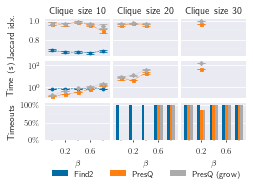

In [7]:
fig = plt.figure()
gs0 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig, wspace=0.05)

_, ax_ratio, ax_time, ax_timeout = plot_results(raw3_results, dict(missing=0.1, clique=10), groupby='added', xlabel='$\\beta$', fig=fig, gs=gs0[0], title='Clique size 10', ylabel=True)
plot_results(raw3_results, dict(missing=0.1, clique=20), groupby='added', xlabel='$\\beta$', fig=fig, gs=gs0[1], title='Clique size 20', legend=True, sharey=[ax_ratio, ax_time, ax_timeout])
plot_results(raw3_results, dict(missing=0.1, clique=30), groupby='added', xlabel='$\\beta$', fig=fig, gs=gs0[2], title='Clique size 30', sharey=[ax_ratio, ax_time, ax_timeout])

fig.savefig('/home/aalvarez/Downloads/3hyper_beta.eps', bbox_inches='tight', pad_inches=0.05)

plt.show()

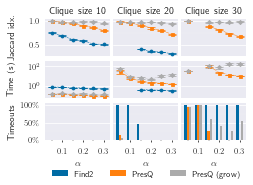

In [8]:
fig = plt.figure()
gs0 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig, wspace=0.05)

_, ax_ratio, ax_time, ax_timeout = plot_results(raw3_results, dict(added=0.0, clique=10), groupby='missing', xlabel='$\\alpha$', fig=fig, gs=gs0[0], title='Clique size 10', ylabel=True)
plot_results(raw3_results, dict(added=0.0, clique=20), groupby='missing', xlabel='$\\alpha$', fig=fig, gs=gs0[1], title='Clique size 20', legend=True, sharey=[ax_ratio, ax_time, ax_timeout])
plot_results(raw3_results, dict(added=0.0, clique=30), groupby='missing', xlabel='$\\alpha$', fig=fig, gs=gs0[2], title='Clique size 30', sharey=[ax_ratio, ax_time, ax_timeout])

fig.savefig('/home/aalvarez/Downloads/3hyper_alpha.eps', bbox_inches='tight', pad_inches=0.05)
plt.show()

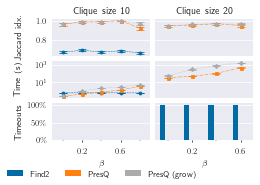

In [9]:
fig = plt.figure()
gs0 = gridspec.GridSpec(ncols=2, nrows=1, figure=fig, wspace=0.05)

_, ax_ratio, ax_time, ax_timeout = plot_results(raw4_results, dict(missing=0.1, clique=10), groupby='added', xlabel='$\\beta$', fig=fig, gs=gs0[0], title='Clique size 10', ylabel=True, legend=True)
plot_results(raw4_results, dict(missing=0.1, clique=20), groupby='added', xlabel='$\\beta$', fig=fig, gs=gs0[1], title='Clique size 20', sharey=[ax_ratio, ax_time, ax_timeout])
#plot_results(raw4_results, dict(missing=0.1, clique=30), groupby='added', xlabel='$\\beta$', fig=fig, gs=gs0[2], title='Clique size 30')

fig.savefig('/home/aalvarez/Downloads/4hyper_beta.eps', bbox_inches='tight', pad_inches=0.05)

plt.show()

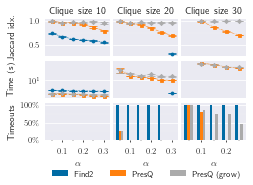

In [10]:
fig = plt.figure()
gs0 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig, wspace=0.05)

_, ax_ratio, ax_time, ax_timeout = plot_results(raw4_results, dict(added=0.0, clique=10), groupby='missing', xlabel='$\\alpha$', fig=fig, gs=gs0[0], title='Clique size 10', ylabel=True)
plot_results(raw4_results, dict(added=0.0, clique=20), groupby='missing', xlabel='$\\alpha$', fig=fig, gs=gs0[1], title='Clique size 20', legend=True, sharey=[ax_ratio, ax_time, ax_timeout])
plot_results(raw4_results, dict(added=0.0, clique=30), groupby='missing', xlabel='$\\alpha$', fig=fig, gs=gs0[2], title='Clique size 30', sharey=[ax_ratio, ax_time, ax_timeout])

fig.savefig('/home/aalvarez/Downloads/4hyper_alpha.eps', bbox_inches='tight', pad_inches=0.05)
plt.show()